In [1]:
import csv
import os

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

RANDOM_SEED = 42

In [2]:
dynamic_csv_path = os.path.join(os.getcwd(), 'models/dynamic_gesture/data/gesture.csv')
dynamic_classifier_path = os.path.join(os.getcwd(), 'models/dynamic_gesture/dynamic_classifier.keras')
dynamic_tflite_path = os.path.join(os.getcwd(), 'models/dynamic_gesture/dynamic_classifier.tflite')

In [3]:
'''
My purpose is to take data from a csv which is a 30-frame long RECORDING of the relative positions of mediapipe 
hand landmark locations where each frame is a csv row. These rows contain coordinates and there are 21 landmarks. 
Thus, there are 42 hand landmarks (21x, 21y), and a 43rd variable representing handedness. Thus there are 43 FEATURES and 
1 y-target variable.

This function takes X_data and converts it
into blocks of 30, such that a sequence of 30 frames with 43 features is one input reference frame for an LSTM model

The shape of the data is thus:

gest = number of RECORDINGS
frames = number of FRAMES per RECORDING
features = number of FEATURES

(gest, frames, features)
or
(gest, 30, 43)

Finally, the y-target is a classification and as such the first of every 30 y_data represents the 0th row of every block, making
the y_data array represent the classification of a corresponding X_data input block. It is encoded

'''

def preprocess_data(X_data, y_data, block_size=30):
    X_data = X_data.copy()
    y_data = y_data.copy()

    # level 1: rows. Level 2: columns
    num_rows = X_data.shape[0]
    num_cols = X_data.shape[1]
    # floor div, ie clip off anything that isnt a multiple of block_size (shouldnt happen due to capture method)
    num_blocks = num_rows // block_size

    # take care of the X values:
    # we want the output to be in "batches" of block_size, so...
    result_shape = (num_blocks, block_size, num_cols)

    # get an index that is the consequence of finding the lowest number of blocks
    array_ind = num_blocks * block_size

    # slice & reshape
    X_result = X_data[:array_ind].reshape(result_shape)
    
    y_result = y_data[::block_size]
    
    return X_result, y_result

In [4]:
def generate_model(X_train, X_test, y_train, y_test, num_classes):

    num_sequences = X_train.shape[0]
    seq_length = X_train.shape[1]
    num_features = X_train.shape[2]

    input_shape = (seq_length, num_features)

    # Create an LSTM model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.LSTM(64, input_shape=input_shape,return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])


    cp_callback = tf.keras.callbacks.ModelCheckpoint(dynamic_classifier_path, verbose=1, save_weights_only=False)
    # es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()
    
    # Train the model 
    model.fit(X_train, 
              y_train,
              validation_data=(X_test, y_test),
              callbacks=[cp_callback],
              epochs=200, 
              batch_size=1)


    
    return model
    

In [5]:
'''
X_lim represents 21 hand landmarks with X,Y coords (therefore x2) and one handedness column
the y_target is actually first in this list so X_lim should start at 1
'''

X_lim = 1 + (21 * 2)
X_range = range(1, X_lim + 1)

X = np.loadtxt(dynamic_csv_path, delimiter=',', dtype='float32', usecols=list(X_range))

y = np.loadtxt(dynamic_csv_path, delimiter=',', dtype='float32', usecols=(0)).astype(np.int64)

In [6]:
X_, y_ = preprocess_data(X, y)

In [7]:
#not enough data yet for stratified kfold
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=RANDOM_SEED)

# encode target variables for classification
ohe = OneHotEncoder(handle_unknown='ignore')

ohe = ohe.fit(y_train.reshape(-1, 1))

y_train = ohe.transform(y_train.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()

num_classes = len(ohe.categories_[0])

In [8]:
m = generate_model(X_train, X_test, y_train, y_test, num_classes)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            27648     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 60867 (237.76 KB)
Trainable params: 60867 (237.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
117/117 [==============================] - ETA: 0s - loss: 0.8376 - accuracy: 0.6752
Epoch 1: saving model to C:\Users\Mickey Nine\PythonP

In [9]:
# Model evaluation
val_loss, val_acc = m.evaluate(X_test, y_test, batch_size=128)

1/1 [==============================] - 1s 814ms/step - loss: 0.0000e+00 - accuracy: 1.0000


In [10]:
# Load saved model
model = tf.keras.models.load_model(dynamic_classifier_path)

In [11]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 1s 731ms/step
[5.6450489e-09 1.4394057e-09 1.0000000e+00]
2


In [12]:
def display_confusion_matrix(y_true, y_pred, report=True): 
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))




1/1 [==============================] - 0s 22ms/step


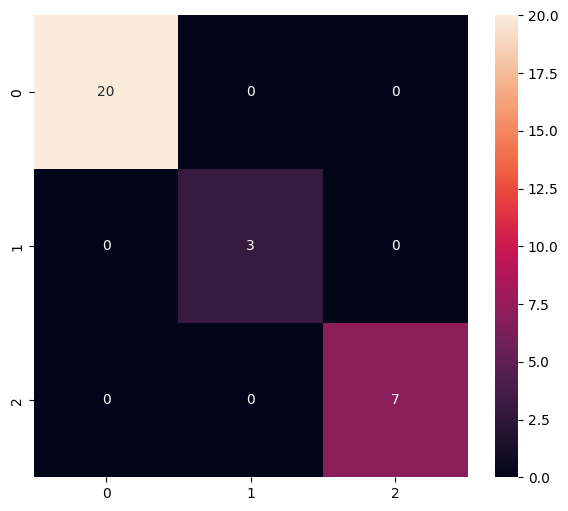

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [13]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

y_pred

# we need to inverse transform y_test for the purposes of comparison (nested array problem)
display_confusion_matrix(ohe.inverse_transform(y_test).flatten(), y_pred)

In [14]:
# Save model
model.save(dynamic_classifier_path)

In [15]:
# Transform model to tflite

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS] 
converter._experimental_lower_tensor_list_ops = False

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(dynamic_tflite_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\MICKEY~1\AppData\Local\Temp\tmpbn8s8d5k\assets


INFO:tensorflow:Assets written to: C:\Users\MICKEY~1\AppData\Local\Temp\tmpbn8s8d5k\assets


81408

In [16]:
interpreter = tf.lite.Interpreter(model_path=dynamic_tflite_path)
interpreter.allocate_tensors()

In [17]:
# Get input/output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [18]:
%%time
# Infer
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 2 ms


In [19]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.03936631 0.7235206  0.23711315]
1
